### Imports & Flag Variable

In [1]:
## Data Management ##
import pandas as pd
import os
## Data Visualizations ##
import matplotlib.pyplot as plt
## Graph Management ##
import networkx as nx
from networkx.algorithms.community import louvain_communities,modularity, greedy_modularity_communities
## Avoid warnings ##
import warnings
warnings.filterwarnings('ignore')

## FLAG VARIABLE to generate the swapped Graphs ##
# True (generate new graphs) / False (read the current graphs from the folder 'generated_graphs')
GENERATE_GRAPHS = False

###
<p style="background-color:#178268; font-family: arial black; color:#FFF9ED; font-size: 300%; text-align: center;">Task 1 - Context</p>


A new created digital marketing agency is planning a campaign of a product and they want to promote it through online entertainment content (streaming platforms), particularly TV shows. However, since they have a limited budget, they need to be strategic about where and how they invest their resources. Their goal is to reach the largest possible audience by identifying the most popular interests and grouping together audiences with similar preferences.

To do this, the agency is using a dataset that contains information about Facebook pages dedicated to various TV shows. These pages are connected through mutual "likes," which indicates that they likely share similar audiences. This dataset can be represented as an undirected graph, where each node is a TV show page and each edge represents a mutual like between two pages.

So the main goals of the further experiments are to identify the most popular TV show pages, which point to the strongest audience interests, and find clusters of similar pages that share overlapping audiences, which can be used to group marketing efforts efficiently.

So the value we can generate with this analysis will allow the agency to maximize their reach and impact while staying within budget by focusing on high-impact interests and well-defined audience groups.

###
<p style="background-color:#178268; font-family: arial black; color:#FFF9ED; font-size: 300%; text-align: center;">Task 2 - Data</p>

- Data Source: https://networkrepository.com/fb-pages-tvshow.php
- Authors: Ryan A. Rossi and Nesreen K. Ahmed
- License: Creative Commons Attribution-ShareAlike License

#### Description
- A node is a TV show's Facebook page. And and edge is a mutual liking of 2 show pages.
- There are two datasets:
    - Facebook page with the medata of the name, id and the new_id (that is the id in the edge dataset).
    - The edges (mutual like) information between 2 pages.

In [2]:
df_nodes = pd.read_csv('data/fb-pages-tvshow.nodes', sep=',')
df_nodes.head()

,id,name,new_id
0,183215455178728,Orange is the New Black,1852
1,282808121926963,狮城有约 Hello Singapore,592
2,179653538737148,DC Cupcakes,1370
3,162816367111296,Gladiatorerna,1263
4,134115896703387,Globo Rural,3042


As we can see, the metadata (df_nodes) has 3 columns:
- id: Facebook's unique id (we are not going to use it)
- name: Name of the TV show
- new_id: real id of the node of the following df_edges

In [3]:
df_edges = pd.read_csv('data/fb-pages-tvshow.edges', sep=',', header=None)
df_edges.columns = ['node_1', 'node_2']
df_edges.head()

,node_1,node_2
0,0,1838
1,0,1744
2,0,14
3,0,2543
4,1,1009


And the df_edges is very self-explanatory, Facebook pages of two different TV shows liking each other's page.

This dataset is suitable for the project because Facebook is one of the most used social platforms and it represents real audience connections through mutual likes, that can help us to identify the most popular pages/TV shows. And moreover, we identify similar communities with this edges to target the best TV shows on the streaming platforms to promote the product with limited budget.

###
<p style="background-color:#178268; font-family: arial black; color:#FFF9ED; font-size: 300%; text-align: center;">Task 3 - IDA & Preprocessing</p>

#### Preprocessing

In [4]:
# Dropping and renaming id columns from df_nodes
df_nodes.drop(columns=['id'], inplace=True)
df_nodes = df_nodes.rename(columns={'new_id':'id'})
df_nodes.shape

(3881, 2)

- There are not null values at the edges or redundant edges.

In [5]:
df_edges.shape

(17262, 2)

In [6]:
df_edges.isna().sum()

node_1    0
node_2    0
dtype: int64

In [7]:
df_edges.drop_duplicates(keep='first')
df_edges.shape

(17262, 2)

- As we can see from the firs cell in this task, df_nodes has a total of 3881 pages/nodes. So there are 11 TV shows we have to drop from df_edges, since they don't have metadata/name.

In [8]:
# Union of all shows at the df_edges
node_1_list = set(df_edges['node_1'].to_list())
node_2_list = set(df_edges['node_2'].to_list())
all_shows = node_1_list.union(node_2_list)

#Number of shows in df_edges
len(all_shows)

3892

In [9]:
# Identify if there are some shows without metadata
medata_shows = set(df_nodes['id'].to_list())
without_medata_shows = medata_shows.symmetric_difference(all_shows)
without_medata_shows

{657, 879, 1385, 1558, 1674, 1811, 2336, 3699, 3781, 3805, 3820}

In [10]:
# Dropping the shows without medata data from df_edges
df_edges = df_edges[~(df_edges['node_1'].isin(without_medata_shows) | df_edges['node_2'].isin(without_medata_shows))]

- Now we convert the ids to real names from the metadata for a better analysis in the future.

In [11]:
# All ids from the node's etadata
nodes_id = df_nodes['id']
# Replacing in the df_edges the ids for the real name of the TV show
for id in all_shows:
    aux = df_nodes[df_nodes['id']==id]['name'].values
    if len(aux)>0:
        name = aux[0]
        df_edges = df_edges.replace({id:name})

In [12]:
# Creating the final graph & removing selfloop_edges
G = nx.from_pandas_edgelist(df=df_edges, source='node_1', target='node_2', create_using=nx.Graph())
G.remove_edges_from(nx.selfloop_edges(G))
# Saving the graph for the future task 9
dir = "generated_graphs"
os.makedirs(dir, exist_ok=True)
nx.write_graphml(G, os.path.join(dir, f"original_graph.graphml"))

#### IDA

- After applying the preprocessing the graph consist in 17203 edges and 3852 nodes.

In [13]:
print("Size:", G.size())
print("Order:", G.order())

Size: 17203
Order: 3852


As we can observe, the Degree Distribution:
- It is a highly right-skewed degree distribution
- The large majority of the nodes are under 10 edges, indicating that this nodes are poor connected within the network
- A small nuber of nodes are very highly connected (over 80 edges), so in somehow there are hub nodes, that in this scenario would be the extremely popular TV shows
- The most liked/popular shows are the following top 10, that almost every of them surpass the threshold of 100. So these TV shows are the most important ones since they are potentially central nodes

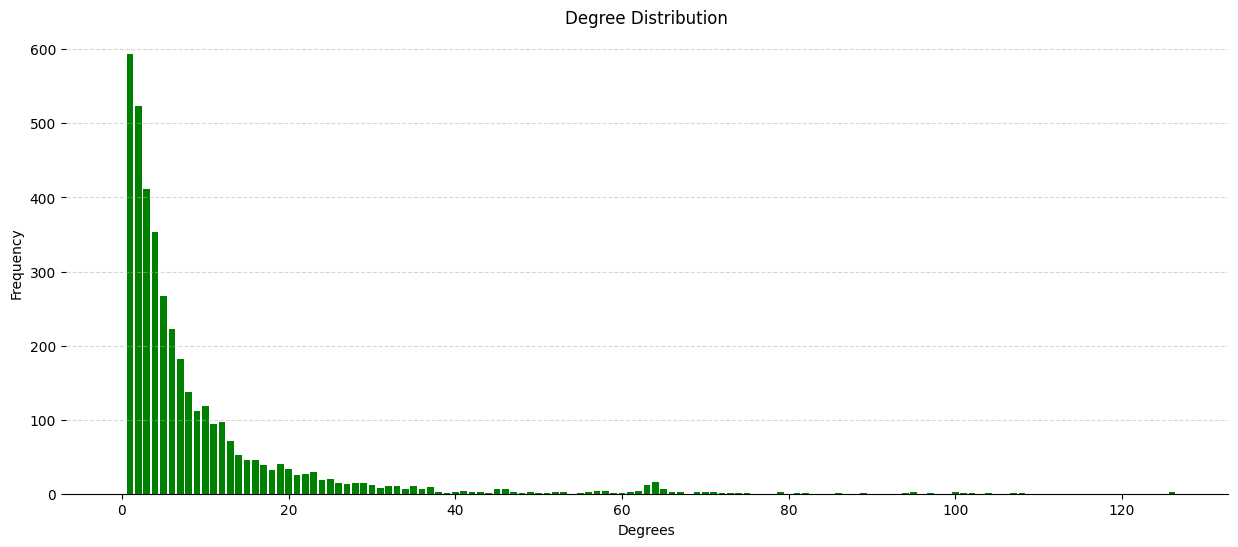

In [14]:
# Histogram plot
degree_hist = nx.degree_histogram(G)
fig = plt.figure(figsize = (15, 6))
plt.title('Degree Distribution')
plt.xlabel('Degrees')
plt.ylabel('Frequency')

# Bars
plt.bar(range(len(degree_hist)), degree_hist, width=0.8, color='green')

# Grid
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Remove the frame
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.show()

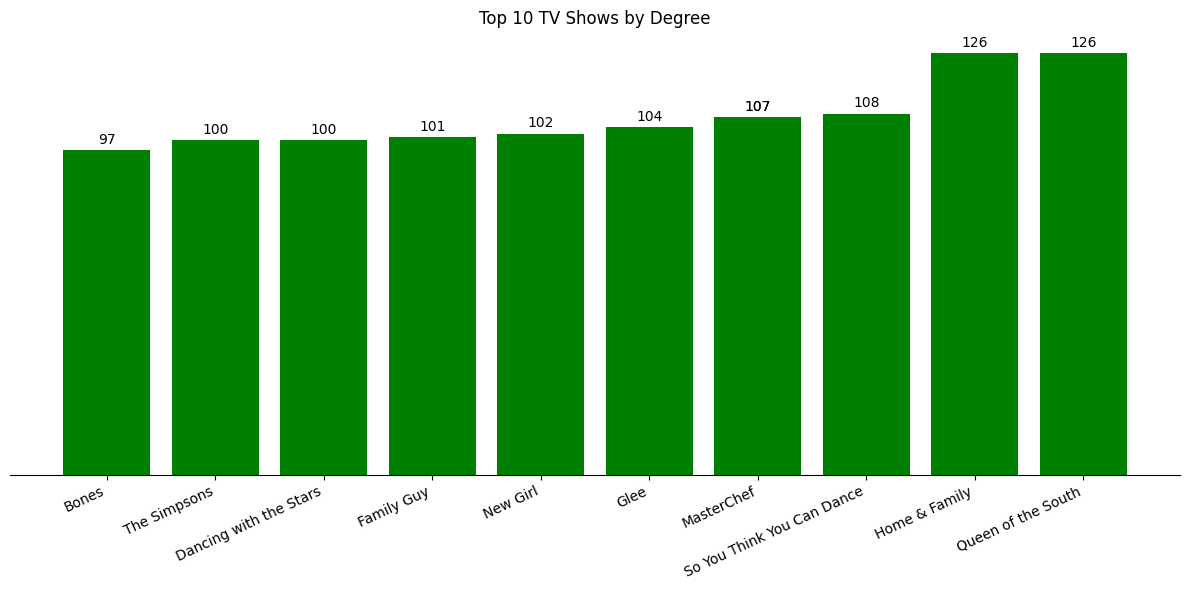

In [15]:
# Top 10 TV shows Degrees
degrees = dict(G.degree())
top_10 = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_df = pd.DataFrame(top_10, columns=['name', 'degree']).merge(df_nodes, on='name')

# Plot
top_10_df_sorted = top_10_df.sort_values('degree')
plt.figure(figsize=(12, 6))

# Bars
bars = plt.bar(top_10_df_sorted['name'], top_10_df_sorted['degree'], color='green')
# Title and Axis
plt.title('Top 10 TV Shows by Degree')
plt.xlabel('')
plt.xticks(rotation=25, ha='right')
plt.gca().axes.get_yaxis().set_visible(False)

# Labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Remove all frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()


- In future tasks, this Top 10 is going to be important because they are the most important shows for our goal, since a lot of people are likely to watch them. So they are vey good candidates to pay for its advertisment and promote our product.

#### Graph Visualization of Top 10 Degrees

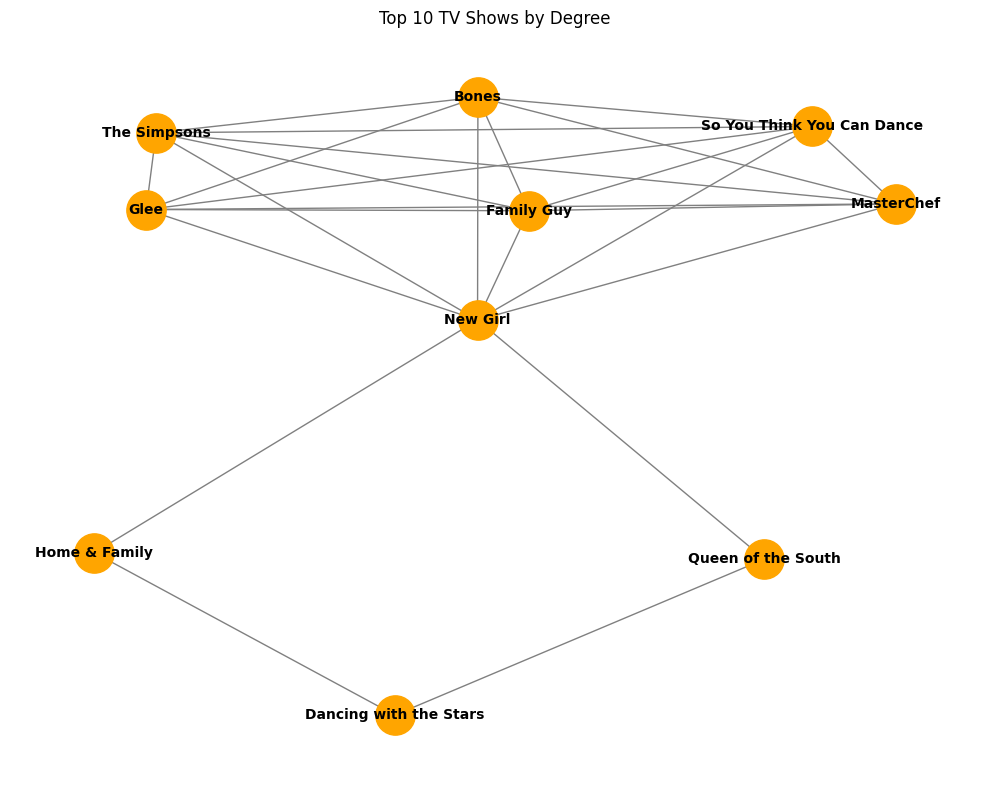

In [16]:
# Visualize the subgraph of the top 10 TV shows by degree
top_10_names = top_10_df['name'].tolist()
subgraph = G.subgraph(top_10_names)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw_networkx_nodes(subgraph, pos, node_color='orange', node_size=800)
nx.draw_networkx_edges(subgraph, pos, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, font_size=10, font_weight='bold')

plt.title('Top 10 TV Shows by Degree')
plt.axis('off')
plt.tight_layout()
plt.show()

- As we can see, "New Girl" plays a key role in connecting diverse parts of the subgraph
- The left cluster, shows us the high connected nodes that could imply an overlap of audience
- Also, we should pay attention to 'Dancing with the Stars', since it could connect to another communities outside the audiency of the Top 10.

###
<p style="background-color:#178268; font-family: arial black; color:#FFF9ED; font-size: 300%; text-align: center;">Task 4 - Graph Generation</p>

Sources:
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.swap.connected_double_edge_swap.html?utm_source=chatgpt.com
- https://www.w3schools.com/python/ref_os_makedirs.asp

In [17]:
# Swap percentages & counts
swap_percentages = [0.1, 0.5, 1, 2, 10]  
num_edges = G.number_of_edges()
swap_count = [int(p * num_edges) for p in swap_percentages]

# Directory and aux array
dir = "generated_graphs"
os.makedirs(dir, exist_ok=True)
swapped_graphs = {}

- Loop to generate/read the swapped graphs thanks to the Flag variable GENERATE_GRAPHS, defined in the first cell of this notebook

In [18]:
for swaps in swap_count:
    if GENERATE_GRAPHS:
        G_swapped = G.copy()
        # Seed for reproducibility & max_tries = swaps*10 to ensure that the swap is done
        G_swapped = nx.double_edge_swap(G_swapped, nswap=swaps, max_tries=swaps*10, seed=1)
        nx.write_graphml(G_swapped, os.path.join(dir, f"G_{int(round(swaps/num_edges, 2)*100)}.graphml"))
    else:
        G_swapped = nx.read_graphml(os.path.join(dir, f"G_{int(round(swaps/num_edges, 2)*100)}.graphml"))
    # Change the key for a better understanding
    key = f"G_{int(round(swaps/num_edges, 2)*100)}"
    swapped_graphs[key] = G_swapped

swapped_graphs

{'G_10': <networkx.classes.graph.Graph at 0x27582ce56d0>,
 'G_50': <networkx.classes.graph.Graph at 0x27585ea7fb0>,
 'G_100': <networkx.classes.graph.Graph at 0x27582d200e0>,
 'G_200': <networkx.classes.graph.Graph at 0x27585fd3f20>,
 'G_1000': <networkx.classes.graph.Graph at 0x27582ca4bf0>}

###
<p style="background-color:#178268; font-family: arial black; color:#FFF9ED; font-size: 300%; text-align: center;">Task 5 - Graphs Properties</p>

In [19]:
# Function to get all the important properties from a Graph
def graph_properties(G, name):
    props = {
        "graph": name,
        "density": nx.density(G),
        "connectedness": nx.is_connected(G),
        "k_core": max(nx.core_number(G).values()),
        "transitivity": nx.transitivity(G),
        "avg_local_cluster_coe": nx.average_clustering(G),
        "assortativity": nx.degree_assortativity_coefficient(G)
    }
    if nx.is_connected(G):
        props["diameter"] = nx.diameter(G)
        props["avg_shortest_path_len"] = nx.average_shortest_path_length(G)
    else:
        props["diameter"] = 'unavailable'
        props["avg_shortest_path_len"] = 'unavailable'
    return pd.Series(props)

In [20]:
# Properties to df
df_properties = graph_properties(G,'original')

# Loop for the dictionary of swapped_graphs
for name, G_swapped in swapped_graphs.items():
    props = graph_properties(G_swapped, name)
    df_properties = pd.concat([df_properties, props], axis=1)

df_properties = df_properties.transpose().reset_index(drop=True)
df_properties

,graph,density,connectedness,k_core,transitivity,avg_local_cluster_coe,assortativity,diameter,avg_shortest_path_len
0,original,0.002319,True,56,0.586508,0.375202,0.552712,19,6.167474
1,G_10,0.002319,False,44,0.332777,0.208843,0.442513,unavailable,unavailable
2,G_50,0.002319,False,21,0.056169,0.031347,0.171359,unavailable,unavailable
3,G_100,0.002319,False,12,0.024856,0.0159,0.055085,unavailable,unavailable
4,G_200,0.002319,False,10,0.018359,0.014997,-0.022579,unavailable,unavailable
5,G_1000,0.002319,False,10,0.018709,0.015944,-0.017941,unavailable,unavailable


**Density**
- This ratio is for measuring comparison between the actual edges and all possible edges in the graph. So as we can see above, the number across all graphs (it doesn't change through all versions because you only change the edges' nodes and no the number of edges) is 0.002319, that is quite low, nearly 0.
- So nearly all nodes are not connected to each other. In this case, most pages share only a few likes to other's pages.

**Connectedness**
- The original graph is totally connected, in other words, we can reach to every single node through some edges starting in a random node. So in somehow, all pages are connected even if they don't have an edge between them.
- But, even a small number of swaps can break key edges that hold the graph together. This can show us that the original structure is likely to contain fragile bridges or critical nodes that affect connectivity.

**Diameter**
- The diameter is the longest path between any two nodes. Only available on the original because in modificated versions are fragmented and disconnected.
- In the original graph we have a Diameter of 19.

**Average Shortest Path Lenght**
- In this graph, this property has a value of 6.167. So it takes on average about 6.17 edges to reach from one node to another one.

**k-core**
- This property is the largest subgraph that contains nodes that each have a degree of at least k. In the our original graph, the largest k-core subgraph is made up of those nodes that share 56 likes. But drops in each rewired versions til 10 in G_1000.
-  As more swaps are applied, dense substructures collapse, and the remaining core becomes smaller and weaker. So, the cohesive regions of the network are being dismantled.

**Transivity**
- Ratio of triangles to triplets in the graph, considering both existing edges and potential edges. It starts from 0.58 and falls really fast to nearly 0 in the G_200 and G_1000.
- So as we can see, in this case a random rewiring effectively eliminates local community structures.

**Average Local Clustering Coefficient**
- It refers to how likely a node’s neighbors are to be connected. It starts on 0.3752 but again the rewiring drops it til a very low value of 0.0018 in the version G_1000 & G_200.

**Assortativity**
- This measures the tendency of nodes to interact with other nodes of similar degrees.
- Initially, high-degree nodes tend to connect with other high-degree nodes (+0.5527), a bit expected as we have seen previously on the visual representation of the top 10 nodes with most degrees. As swaps increase and node connections become more random to even disassortative behavior at high swap levels. This is could be because the nodes don't have a strog clustering tendency.

###
<p style="background-color:#178268; font-family: arial black; color:#FFF9ED; font-size: 300%; text-align: center;">Task 6 - Central Nodes</p>

The measures that we are going to use are the following
- Closeness Centrality
- Betweenness Centrality
- Eigenvector Centrality

We are not going to use the Degree Centrality because it would be redundant since we already have this information in the Task 3. But we keep the name of these top 10 shows because are the most popular of the graph.

In [21]:
# Creating df_centrality with the measures
df_centrality = pd.DataFrame({
    'node': list(G.nodes()),
    'closeness': list(nx.closeness_centrality(G).values()),
    'betweenness': list(nx.betweenness_centrality(G).values()),
    'eigenvector': list(nx.eigenvector_centrality(G).values()),  
})

# Rankings to see the whole picture
df_centrality['closeness_rank'] = df_centrality['closeness'].rank(ascending=False)
df_centrality['betweenness_rank'] = df_centrality['betweenness'].rank(ascending=False)
df_centrality['eigenvector_rank'] = df_centrality['eigenvector'].rank(ascending=False,method='dense')

#### Closeness & Betweenness Centrality

In [22]:
# Top 10 by closeness centrality
top_10_closeness = df_centrality.nlargest(10, 'closeness')
print('Top 10 Closeness')
display(top_10_closeness)
# Top 10 by betweenness centrality
top_10_betweenness = df_centrality.nlargest(10, 'betweenness')
print('Top 10 Betweeness')
display(top_10_betweenness)

Top 10 Closeness


,node,closeness,betweenness,eigenvector,closeness_rank,betweenness_rank,eigenvector_rank
413,Queen of the South,0.265953,0.107580,0.012370,1.0,1.0,82.0
411,Home & Family,0.264274,0.094793,0.012371,2.0,2.0,81.0
592,Access,0.259571,0.065030,0.002740,3.0,5.0,97.0
798,The Tonight Show Starring Jimmy Fallon,0.253940,0.077338,0.000242,4.0,3.0,357.0
771,The Voice,0.249030,0.061517,0.000435,5.0,6.0,262.0
456,The List,0.246291,0.033406,0.001335,6.0,11.0,168.0
831,America's Got Talent,0.245772,0.028124,0.000525,7.0,14.0,217.0
1793,The Insider,0.245052,0.024302,0.003108,8.0,19.0,96.0
561,The Biggest Loser,0.243411,0.008906,0.000594,9.0,112.0,201.0
609,Entourage,0.242399,0.023489,0.000461,10.0,21.0,239.0


Top 10 Betweeness


,node,closeness,betweenness,eigenvector,closeness_rank,betweenness_rank,eigenvector_rank
413,Queen of the South,0.265953,0.107580,0.012370,1.0,1.0,82.0
411,Home & Family,0.264274,0.094793,0.012371,2.0,2.0,81.0
798,The Tonight Show Starring Jimmy Fallon,0.253940,0.077338,0.000242,4.0,3.0,357.0
139,The Voice Global,0.228167,0.069263,0.000088,51.5,4.0,470.0
592,Access,0.259571,0.065030,0.002740,3.0,5.0,97.0
771,The Voice,0.249030,0.061517,0.000435,5.0,6.0,262.0
28,MasterChef,0.233805,0.045304,0.137216,27.0,7.0,4.0
37,American Idol,0.233224,0.038575,0.033598,28.0,8.0,64.0
1128,Top Chef,0.225945,0.034733,0.000454,69.0,9.0,245.0
505,tagesschau,0.203037,0.034695,0.000035,486.0,10.0,736.0


- As seen in Top 10 TV shows by Degree, again the top 2 are "Queen of the South" and "Home & Family" with the highest betweenness and closeness centrality. So this information provide us that they act like bridges between different pages.

- On the other hand, we have two nodes that they didn't appear at the top 10 with most degrees, "The Tonight Show Starring Jimmy Fallon" and "The Voice Global". They have a high betweenness, so this could lead us that are very good positioned to become important links between other nodes.
    - But "The voice" has a low closeness,meaning that this node isn't good to spread information quickly and efficently

- However, this measures focus on structural efficiency and bridging roles, not actual popularity or influence. They don’t account for how important or well-connected a page’s neighbors are — which is crucial for marketing impact goals in our context.

#### Eigenvector Centrality

In [23]:
top_10_eigen = df_centrality.nlargest(10, 'eigenvector')
display(top_10_eigen)

,node,closeness,betweenness,eigenvector,closeness_rank,betweenness_rank,eigenvector_rank
60,So You Think You Can Dance,0.236403,0.014418,0.138495,22.0,49.0,1.0
48,New Girl,0.239609,0.012343,0.138456,14.0,64.0,2.0
68,Bones,0.225323,0.001266,0.137237,75.0,815.0,3.0
28,MasterChef,0.233805,0.045304,0.137216,27.0,7.0,4.0
50,Family Guy,0.232619,0.007744,0.136803,31.0,142.0,5.0
91,Bob's Burgers,0.226983,0.001774,0.136649,59.0,664.0,6.0
63,The Simpsons,0.237262,0.027631,0.136449,19.0,15.0,7.0
86,Brooklyn Nine-Nine,0.237467,0.006223,0.136389,18.0,189.0,8.0
64,Glee,0.237760,0.023406,0.136152,16.0,22.0,9.0
75,Hell's Kitchen,0.225310,0.003087,0.135848,76.0,424.0,10.0


- This measures highlights the importance of the balance between the number of connections and the importance of neighbours.

- The top nodes in this measure also appeared in the top 10 with the most Degrees "So You Think You Can Dance", "New Girl", and "Bones". But also there are new node in top like 'Hell's Kitchen','Brooklyn Nine-Nine' and 'Bob's Burgers'.

- On the other hand, "Queen of the south" and "Home & Family" with highest centrality measures are not even in the top 10 eigenvector rank. So, this can mean that the quality of the neighbours is quite low.

- So these top is important for the goals of the project, since identifies pages that are not only popular but also connected to other influential pages. In marketing, this means promoting through pages that sit at the core of audience interest, amplifying the campaign’s visibility and reach through impactful connections.

###
<p style="background-color:#178268; font-family: arial black; color:#FFF9ED; font-size: 300%; text-align: center;">Task 7 - Community Discovery</p>

The algoritm that we are using are Louvain and Greedy Modularity
- Louvain discovers communities bottom-up, hierirchical and fuses communities until modularity cannot be improved
- Greedy Modularity starts with each node as its own community, then greedily merges the best pair to increase modularity.

We are not going to use the Girvan-Newman Algorithm since it is a really time-consuming algorithm in this scenario with a large number of nodes.

In [24]:
# df_cmmunities to store modularity
df_communities = pd.DataFrame(columns=('graph', 'algorithm','modularity','clusters number'))

# Function to append the results to the previous df_communities
def append_results(df, graph, algorithm, modularity, clusters_count, ):
    aux = pd.DataFrame({'graph':[graph],'algorithm':[algorithm],'clusters number':[clusters_count],'modularity':[modularity]})
    df = pd.concat([df,aux],ignore_index=True)
    return df

#### Original Graph

In [25]:
## Louvain Algorithm ##
lc = louvain_communities(G, seed=1)
df_communities = append_results(df_communities, 'Original','louvain', modularity(G,lc), len(lc))

In [26]:
## Greedy Algorithm ##
greedy = greedy_modularity_communities(G)
df_communities = append_results(df_communities, 'Original','greedy', modularity(G,greedy), len(greedy))

In [27]:
df_communities

,graph,algorithm,modularity,clusters number
0,Original,louvain,0.868033,47
1,Original,greedy,0.814385,61


- Both algorithms modulairy are between 0.3 and 0.7, this range usually is considered reasonable good, because it means that inside the graph are meaningful communities structure in both clusterings. However, Louvain achieves a higher modularity (0.868 vs 0.814), indicating it found communities with stronger intra-community connections. Also the Greedy finds more clusters, it may be detect smaller and more fragmented groups.

#### Generated Graphs

In [28]:
## Loop to apply algorithms to the Generated Graphs
for name, G_swapped in swapped_graphs.items():
    # Louvain
    lc_swapped = louvain_communities(G_swapped, seed=1)
    df_communities = append_results(df_communities, name, 'louvain', modularity(G_swapped, lc_swapped), len(lc_swapped))
    # Greedy
    greedy_swapped = greedy_modularity_communities(G_swapped)
    df_communities = append_results(df_communities, name, 'greedy', modularity(G_swapped, greedy_swapped), len(greedy_swapped))

In [29]:
df_communities

,graph,algorithm,modularity,clusters number
0,Original,louvain,0.868033,47
1,Original,greedy,0.814385,61
2,G_10,louvain,0.717034,40
3,G_10,greedy,0.677849,49
4,G_50,louvain,0.374106,29
5,G_50,greedy,0.349031,40
6,G_100,louvain,0.291368,26
7,G_100,greedy,0.287271,26
8,G_200,louvain,0.291185,25
9,G_200,greedy,0.285798,29


- After 10% swaps, the modularity drops significantly around a 15% in both algorithms, and the number of clusters also decreases, showing early signs of degradation among communities.

- In G_50 and G_100, the modularity falls completely down, indicating that the network's community structure is broken. The number of clusters continues to decrease.

- Finaly, at G_200 and G_1000, modularity stabilizes at a low level (0.29) in comparison to the previous graphs, showing that excessive randomization reaches a saturation point where further swaps have minimal additional effect.

- In overall, as the number of swaps increases, the community structure deteriorates rapidly, especially beyond 50% rewiring. Both Louvain and Greedy algorithms reflect this breakdown, with Louvain consistently detecting slightly higher modularity in all the generated graphs.

#### Combine the Clusterings

In [30]:
df_modularity_compare = pd.DataFrame(columns=('graph', 'modularity_louvain_swapped','modularity_greedy_swapped'))

## Loop for both algorithms
for key, G_swapped in swapped_graphs.items():
    # Original Louvain clustering on swapped graphs
    mod_louvain = modularity(G_swapped, lc)
    # Original Greedy clustering on swapped graphs
    mod_greedy = modularity(G_swapped, greedy)
    df_modularity_compare = pd.concat([df_modularity_compare,
                            pd.DataFrame([{'graph': key, 'modularity_louvain_swapped': mod_louvain, 'modularity_greedy_swapped': mod_greedy}])], ignore_index=True)

df_modularity_compare

,graph,modularity_louvain_swapped,modularity_greedy_swapped
0,G_10,0.703876,0.658308
1,G_50,0.303422,0.283140
2,G_100,0.106015,0.100905
3,G_200,0.012601,0.011444
4,G_1000,0.001382,0.002492


- As we can imagine from the previous results above, the modularity scores of the original algorithms decline sharply as the amount of edge swaps increases, causing a loss of alignment between the original community structure. At 10% swaps, the structure is still somewhat preserved (modularities of 0.70 and 0.65). But by 50% swaps, modularity drops drastically, and at 100% or more, modularity becomes very low (less than 0.1), showing the original clustering no longer corresponds to meaningful structure in the rewired graphs.

- In conclusion, the original graph's modular structure is not robust to significant perturbations, and that modularity is sensitive to structural changes, as we have seen in this results and the other ones.

#### Community Clustering Louivan

In [31]:
# largest community from lc (og graph) & Degrees
largest_community = max(lc, key=len)
community_degrees = {node: G.degree(node) for node in largest_community}
largest_community = pd.DataFrame(list(community_degrees.items()), columns=['name', 'degree'])

# Adding eigenvector 
eigenvector_dict = nx.eigenvector_centrality(G)
largest_community['eigenvector'] = largest_community['name'].map(eigenvector_dict)

# Sort by degree and Top 10
top10_community = largest_community.sort_values('degree', ascending=False).head(10)
top10_community

,name,degree,eigenvector
239,Home & Family,126,0.012371
108,Queen of the South,126,0.012370
198,Access,62,0.002740
328,The Tonight Show Starring Jimmy Fallon,58,0.000242
165,Days of our Lives,57,0.000182
184,The Voice,53,0.000435
53,The Biggest Loser,52,0.000594
227,America's Got Talent,47,0.000525
301,Parks and Recreation,47,0.000504
392,The Office,45,0.000156


- From this community, the top-ranked shows like Home & Family and Queen of the South have emerged as highly connected within their audience cluster. These shows are not only central (high degree) but also influential, biggest eigenvector values of top10, suggesting they are excellent targets for marketing due to their potential to reach and influence a broad network of fans.

- But, a bad point to mention is that in comparison with other top values of eigenvector, their values are very low almmost around 0.

###
<p style="background-color:#178268; font-family: arial black; color:#FFF9ED; font-size: 300%; text-align: center;">Task 8 - Conclusions and Future Work</p>

**Summary**
- The graph of TV show facebook pages is a fully connected network. 
- It also has moderate transivity and assortativity among nodes of 0.58 and 0.55. 
- We have targered the most important nodes, that in this case would be the one with most degrees.
- We calculated 3 types of centrality properties and the eigenvector centrality is the most important among them for our goals. 
- While running the two community detection algorithms, we got 47 and 61 clusters and selected Louvain due to its better modularity value. This value indicates that the partition between clusters are very good and are well separated. 
- Also, while applying all the experiments to the generated swapped-edge grapgh, we have noticed that the structure of the original graph is delicated. Since, all the properties have been reduced due to this fact.

**Retrospective**
- The main goal was to identify the most popular TV shows pages, and we have done this job while identifying the nodes with the most degree and the eigenvector centrality
- On the other hand, we have identify clusters of TV shows with the Leuvan algorithm, so we can identify the top Tv shows of each cluster to don't waste resource in only one cluster, and pay the advertisments for other shows in other important clusters.

**Course of Action**
- The marketing agency should pay for the ads of a balanced TV shows we have discussed previously, they will be the following:
    - 'Home & Family' and 'Queen of the South': most degrees in the biggest cluster, Top10 most degrees in its own cluster and are key in the subgrapgh of top10 Tv shows by degree.
    - 'New Girl: bridge between communities, top2 eignvector value and top10 degrees.
    - 'Bones' and 'So You Think You Can Dance': very good eigenvector and top10 degrees.

**Generated Value** 
- By focusing ad placements around these shows, the agency can efficiently focus on well-defined, engaged audience segments, amplifying campaign reach and minimizing wasteful spending on low-impact channels

**Pitfalls**
- We have to considerate the also the 'temporal' feature, usually the influence/popularity of a show changes over time.
- Instead, of exploring only one community we could have dug into further communities and how they are distributed and how are linked by each others.

**Future Work**
- Appying the algorithm of Girvan-Newman, since it could get a better modularity than the Leuvan
- Adding more medata to the Datafram (like type of show or country), could generate more graphs and could provide us more gradularity and information about the nodes and their roles.